# QAOA for the Max-Cut
First we import the needed libraries

In [10]:
%matplotlib inline
#math and plotting
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
import pylab as pl

#qiskit stuff
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram

#Optimizers
from scipy.optimize import minimize, LinearConstraint, differential_evolution

#Noises
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError
from qiskit.providers.aer.noise import thermal_relaxation_error

Then we generate graph G(E,V) with n=|V| nodes and m=|E| edges.

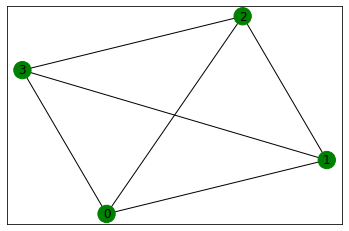

In [11]:
# Generating the graph G(V,N)
def diamond_graph(): #Starmon 5 shape
    n     = 5
    V     = np.arange(0,n,1)
    E     =[(0,1,1.0),(0,2,1.0),(0,3,1.0),(4,0,1.0)] 
    G     = nx.Graph()
    G.add_nodes_from(V)
    G.add_weighted_edges_from(E)
    return G

def two_nodes_graph():
    n     = 2
    V     = np.arange(0,n,1)
    E     =[(0,1,1.0)]
    G     = nx.Graph()
    G.add_nodes_from(V)
    G.add_weighted_edges_from(E)
    return G

def fournodes_3reg_graph(): #4-node 3-regular yutsis graph
    n     = 4
    V     = np.arange(0,n,1)
    E     =[(0,1,1.0), (1,2,1.0), (2,3,1.0), (3,0,1.0), (0,2,1.0), (1,3,1.0)]
    G     = nx.Graph()
    G.add_nodes_from(V)
    G.add_weighted_edges_from(E)
    return G

G = fournodes_3reg_graph()
n = len(G.nodes())
E = G.edges()

# Generate plot of the Graph
colors = ['g' for node in G.nodes()]
nx.draw_networkx(G, node_color=colors)

Now we build the circuit (depending on two parameters $\gamma$ and $\beta$) that implements the gates $U = e^{-i\gamma H}$ and $U = e^{-i\beta H_{mixing}}$ and measures all the qubits. 

this is gamma_ 0 : g and this is beta_ 0 : b
this is gamma_ 1 : a and this is beta_ 1 : e
this is gamma_ 2 : m and this is beta_ 2 : t


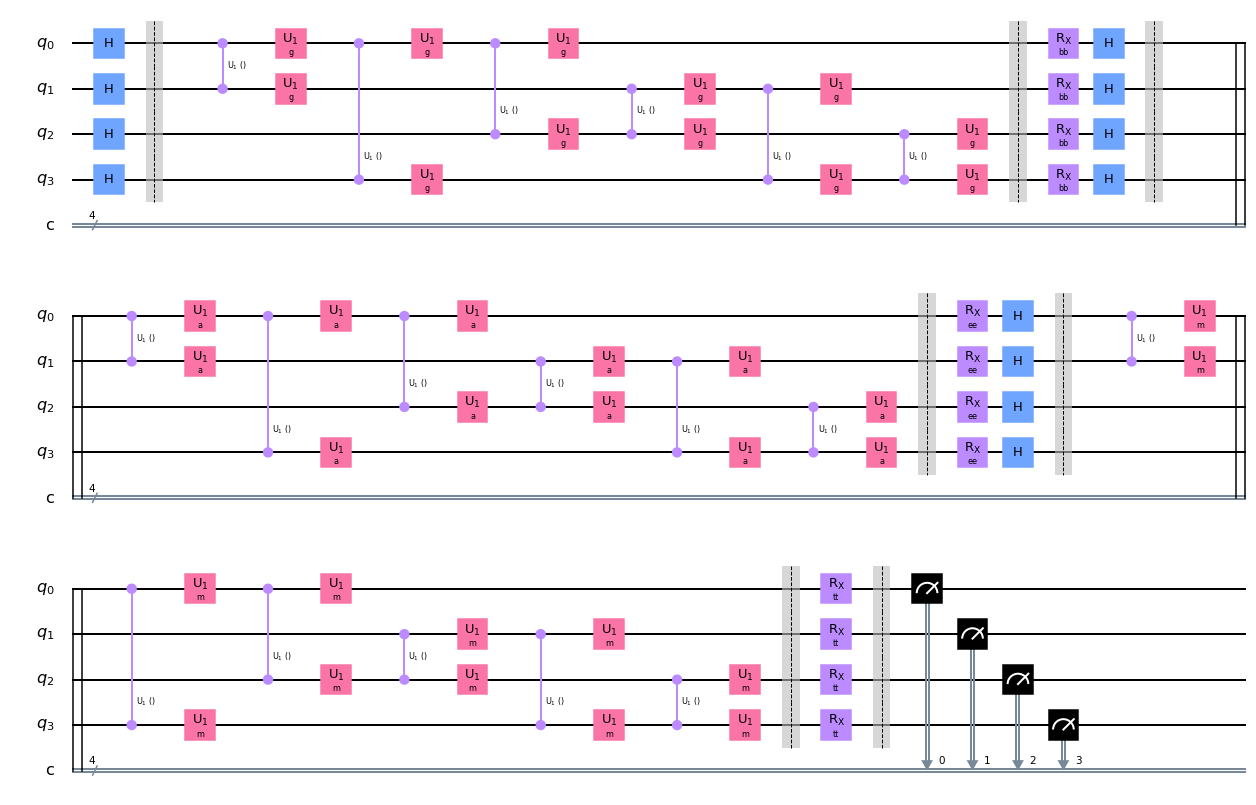

In [20]:
def circuit_ansatz(G, gamma, beta , p=1): #gamma and beta are p-arrays or lists
    n = len(G.nodes())
    E = G.edges()

    QAOA = QuantumCircuit(n, n)

    for i in range(p):
        gamma_i = gamma[i]
        beta_i = beta[i]
        print('this is gamma_',i ,':', gamma_i, 'and this is beta_',i ,':', beta_i )
        QAOA.h(range(n))

        QAOA.barrier()
        for edge in E:
            k = edge[0]
            l = edge[1]
            QAOA.cu1(-2*gamma_i, k, l) #Controlled-Z gate with a -2*gamma phase
            QAOA.u1(gamma_i, k) #Rotation of gamma around the z axis
            QAOA.u1(gamma_i, l) #

        QAOA.barrier()
        QAOA.rx(2*beta_i, range(n)) #X rotation

    QAOA.barrier()
    QAOA.measure(range(n),range(n)) #measures the circuit

    return QAOA

p=3
gamma = [str(f'gamma{layer+1}') for layer in range(p)]
beta = [str(f'beta{layer+1}') for layer in range(p)]
circuit_ansatz(G, 'gamma', 'beta', p = p).draw(output = 'mpl') #draw the circuit

Now we define a function that executes the circuit a number of times given by the parameter shots, and returns the number of counts of every measured n-qubit state. 

In [26]:
def execute_circuit(G, gamma, beta, backend, shots, p=1, noise_model = None ): #returns an instance of the Results class

    QAOA = circuit_ansatz(G, gamma, beta) #creates the circuit

    job = execute(QAOA, backend=backend, shots=shots, noise_model=noise_model, p = p)
    #job_monitor(job)
    results = job.result()
    counts = results.get_counts() #dictionary with keys 'bit string x' and items 'counts of x'
    return counts

And a function takes a bit string x representing a state (partition of the graph G) and measures the cost of the state represented by that bitstring. 

In [27]:
def cost_function_C(x,G): #input x is a list
    E = G.edges()
    C = 0
    for vertice in E:
        e1 = vertice[0]
        e2 = vertice[1]
        w = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
    return C

Finally, we need to calculate the expectation value of the cost function in the final state, by summing the cost of every measured state in the final state |$\gamma$,$\beta$> and dividing by the number of times we measure (shots). We also define a function that returns the solution state and the cost function of that state (the solution is taken to be the state with the highest cost function within all the measured states)

In [28]:
def get_expectval(counts, shots):
    total_cost = 0
    for sample in list(counts.keys()):
        x = [int(bit_num) for bit_num in list(sample)] #the bit string is saved as a list
        cost_x = cost_function_C(x,G)
        total_cost += counts[sample]*cost_x
    avr_cost = total_cost/shots
    return avr_cost

def get_solution(counts): #takes as the solution the state with the highest cost within all the measured states
    solution_cost = 0
    for sample in list(counts.keys()):
        x = [int(bit_num) for bit_num in list(sample)] #the bit string is saved as a list
        cost_x = cost_function_C(x,G)
        if cost_x > solution_cost:
            solution = x
            solution_cost = cost_x
    print(f'The solution is the state {solution} with a cost value of {solution_cost}')
    return solution, solution_cost

# Local simulator
## Solutions grid
We now represent the cost function over the $\gamma,\beta$ space. Note that it always holds that $\gamma$ is periodic in (0,$\pi$) and $\beta$ is periodic in (0,$2\pi$). (See appendix of the paper Improving the Performance of Deep Quantum Optimization Algorithms with Continuous Gate Sets. Also explained in the report smit sent.) 

-----> Probably an error in the plotting of the function, periodicities are interchanged

In [29]:
backend = Aer.get_backend("qasm_simulator")
shots = 1000

gamma_max = 2*np.pi
beta_max = 2*np.pi
steps = 20

gamma_list = np.linspace(0,gamma_max,steps) ; beta_list = np.linspace(0,beta_max,steps)
avr_cost_grid = np.zeros((len(gamma_list),len(beta_list)))

for i in range(len(gamma_list)): #gamma and beta grid between 2pi and 2pi
    gamma = [gamma_list[i]]
    for j in range(len(beta_list)):
        beta = [beta_list[j]]
        counts = execute_circuit(G, gamma, beta, backend, shots)
        avr_cost = get_expectval(counts, shots)

        avr_cost_grid[i,j] = avr_cost

f = pl.figure(facecolor='w', edgecolor='k')
pl.imshow(avr_cost_grid, interpolation = 'bicubic', extent = [0,beta_max,0,gamma_max])
pl.title('Ideal parameter grid', fontsize=8)
pl.colorbar()
pl.xlabel(r'$\beta$')
pl.ylabel(r'$\gamma$')
pl.show()

this is gamma_ 0 : 0.0 and this is beta_ 0 : 0.0


TypeError: run() got an unexpected keyword argument 'p'

## Noise
Now we define a model with noise. In this model we want to mimic the kind of noise we would encounter in Starmon 5. This basic model only accounts for the relaxation error T1 and the dephasing error T2. The execution time of the gates is taken as 20 ns for single qubit gates and 45 ns for two qubit gates (taken from Starmon 5 fact sheet) T1 and T2 for Starmon 5??

In [9]:
# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError
from qiskit.providers.aer.noise import thermal_relaxation_error

# T1 and T2 values (from analysis)
T1 = 45e-3 
T2 = 20e-3

#Gate execution times
T_1qubit_gates = 20e-6
T_2qubit_gates = 60e-6

# Thermal relaxation
single_qubit_error = thermal_relaxation_error(T1, T2, T_1qubit_gates) #single qubit gates
two_qubits_error = thermal_relaxation_error(T1, T2, T_2qubit_gates) #two qubit gates

#missing gate (in)fidelity error. 1qubit = 1.5 × 10 −3 , 2qubit = 4 × 10 −2


# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(single_qubit_error, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(two_qubits_error, ['CU1'])

In [11]:
# Importing noise model from a IBM backend
from qiskit import IBMQ
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend)

ibmqfactory.load_account:WARNING:2020-12-14 16:45:05,707: Credentials are already in use. The existing account in the session will be replaced.


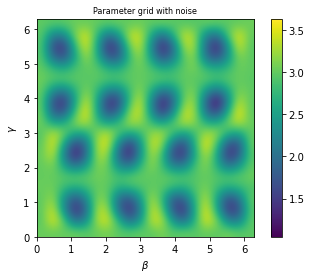

In [12]:
# Making the grid with noise
backend = Aer.get_backend("qasm_simulator")

shots = 1000

gamma_max = 2*np.pi
beta_max = 2*np.pi
steps = 20

gamma_list = np.linspace(0,gamma_max,steps)
beta_list = np.linspace(0,beta_max,steps)

avr_cost_grid = np.zeros((len(gamma_list),len(beta_list)))

for i in range(len(gamma_list)): #gamma and beta grid between 2pi and 2pi
    gamma = gamma_list[i]
    for j in range(len(beta_list)):
        beta = beta_list[j]
        counts = execute_circuit(G, gamma, beta, backend, shots, noise_model=noise_model)
        avr_cost = get_expectval(counts, shots)

        avr_cost_grid[i,j] = avr_cost

f = pl.figure(facecolor='w', edgecolor='k')
pl.imshow(avr_cost_grid, interpolation = 'bicubic', extent = [0,beta_max,0,gamma_max])
plt.title('Parameter grid with noise', fontsize=8)
pl.colorbar()
pl.xlabel(r'$\beta$')
pl.ylabel(r'$\gamma$')
pl.show()

## Optimizing the expectation value of the cost function
We need a float objective function to minimize that takes gamma and beta and returns the negative of the expectation value of the cost function ( the negative because we want to maximize the expectation value). In the case of a 2 node graph, the solution's states are 01 and 10, and the maximum value of the cost function is 1. 

In [39]:
def expect_value_function(parameters, backend, G, shots, noise_model = None):
    gamma = []
    beta = []
    for i in range(p):
        gamma.append(parameters[i])
    for i in range(p,2*p):
        beta.append(parameters[i])
    counts = execute_circuit(G,gamma,beta,backend,shots, noise_model = noise_model)
    avr_cost = get_expectval(counts, shots)
    return -avr_cost 

When using a local optimizer method (Sequential Least Squares Programming) it doesn't seem to work very well. The expectation values after optimization are not very high (around 0.5 normally). 

In [40]:
# IBM's simulator backend
backend = Aer.get_backend("qasm_simulator")
shots = 1000
p = 2

# setting the bounds for gamma and beta
bounds = ((0, np.pi), (0, 2*np.pi)) 

#initial values
x0 = np.random.randn(2*p)

# Nelder-Mead optimizer:
max_expect_value = minimize(expect_value_function, x0=x0,args=(backend,G,shots), options={'disp': True}, method = 'Nelder-Mead')

# SLQP optimizer:
#max_expect_value = minimize(expect_value_function, x0=np.random.randn(2),args=(backend,G,shots), bounds = bounds, options={'disp': True}, method = 'SLQP')

optimal_gamma, optimal_beta = max_expect_value['x']

counts = execute_circuit(G,optimal_gamma,optimal_beta,backend,shots)
solution, solution_cost = get_solution(counts)

print('Optimal gamma, beta = ', optimal_gamma, optimal_beta)
print('Expectation value of the cost function = ', -max_expect_value.get('fun'))
print('Approximation ratio = ', -max_expect_value.get('fun')/solution_cost )

plot_histogram(counts,figsize = (8,6),bar_labels = False)

-0.5334683164179475 0.4870647797336816


CircuitError: 'Expression cannot bind non-real or non-numeric values ({Parameter(rx[0]): [0.4870647797336816, -0.08788610266312237, 0.4870647797336816, -0.08788610266312237]}).'

Trying with a global optimizer (the differential_evolution) from scipy gives much better resuls (idea from Mahabubul Alam, Abdullah Ash-Saki, Swaroop Ghosh paper). This optimizer also needs a lot more evaluation of the objective function, so the running time is quite larger. This will be specially notable when using real hardware.

The solution is the state [1, 0, 0, 0, 0] with a cost value of 4.0
Optimal gamma, beta =  0.4639273252707641 2.9131639810547894
Expectation value of the cost function =  2.1137
Approximation ratio =  0.528425


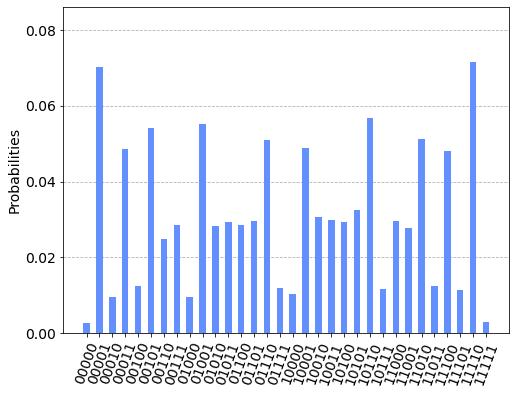

In [80]:
#Using a global optimizer:
max_expect_value = differential_evolution(expect_value_function,args=(backend,G,shots), bounds=bounds)
optimal_gamma, optimal_beta = max_expect_value['x']

counts = execute_circuit(G,optimal_gamma,optimal_beta,backend,shots)
solution, solution_cost = get_solution(counts)

print('Optimal gamma, beta = ', optimal_gamma, optimal_beta)
print('Expectation value of the cost function = ', -max_expect_value.get('fun'))
print('Approximation ratio = ', -max_expect_value.get('fun')/solution_cost )

plot_histogram(counts,figsize = (8,6),bar_labels = False)

## Global optimizer with noise

The solution is the state [1, 0, 0, 0, 0] with a cost value of 4.0
Optimal gamma, beta =  0.43724142698447643 6.120364933191336
Expectation value of the cost function =  2.1062
Approximation ratio =  0.52655


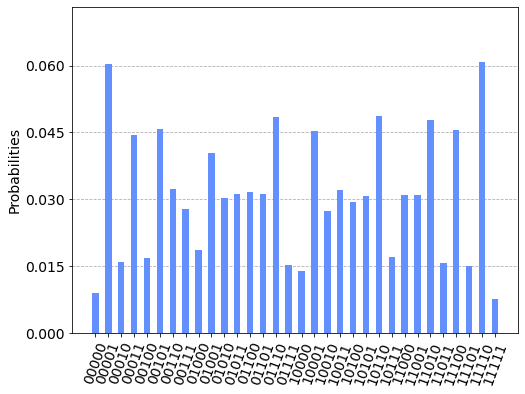

In [82]:
max_expect_value = differential_evolution(expect_value_function,args=(backend,G,shots,noise_model), bounds=bounds)
optimal_gamma, optimal_beta = max_expect_value['x']

counts = execute_circuit(G,optimal_gamma,optimal_beta,backend,shots)
solution, solution_cost = get_solution(counts)

print('Optimal gamma, beta = ', optimal_gamma, optimal_beta)
print('Expectation value of the cost function = ', -max_expect_value.get('fun'))
print('Approximation ratio = ', -max_expect_value.get('fun')/solution_cost )

plot_histogram(counts,figsize = (8,6),bar_labels = False)

# Quantum Inspire

Now the same but with the quantum inspire backend . Expectation values are lower (as expected).

In [ ]:
from quantuminspire.credentials import save_account
from quantuminspire.qiskit import QI

save_account('baeb3be4d807b3b6d170dc2d6de5c1b02b1606d1') #saves account with my API token
QI.set_authentication()

qi_backend = QI.get_backend('QX single-node simulator') #
shots = 50

# setting the bounds for gamma and beta
bounds = ((0, 2*np.pi), (0, 2*np.pi)) 

#SLSQP local minimizer
max_expect_value = minimize(expect_value_function, x0=np.random.randn(2),args=(qi_backend,G,shots), bounds=bounds, options={'disp': False}, method = 'SLSQP')
optimal_gamma, optimal_beta = max_expect_value['x']

print('Optimal gamma, beta = ', optimal_gamma, optimal_beta)
print('Expectation value of the cost function = ', -max_expect_value.get('fun'))

counts = execute_circuit(G,optimal_gamma,optimal_beta,backend,100)
get_solution(counts)
plot_histogram(counts,figsize = (8,6),bar_labels = False)

Global optimizer (takes quite a long time so I did not run it yet, but it should work as good as with the IBM simulator)

In [ ]:
# using the global optimizer
max_expect_value = differential_evolution(expect_value_function,args=(qi_backend,G,shots), bounds=bounds)
optimal_gamma, optimal_beta = max_expect_value['x']

print('Optimal gamma, beta = ', optimal_gamma, optimal_beta)
print('Expectation value of the cost function = ', -max_expect_value.get('fun'))

counts = quantum_circuit(G,optimal_gamma,optimal_beta,backend,100)
plot_histogram(counts,figsize = (8,6),bar_labels = False)